In [1]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Reader, SVD, KNNBasic, Dataset
from surprise.model_selection import train_test_split as surprise_train_test_split
from surprise.accuracy import rmse

In [3]:
TOP_N = 5
ALPHA = 0.6 # Weight for collaborative filtering (CF), (1 - ALPHA) for content-based

In [4]:
Movies = pd.read_csv("/Users/sarthakjain/Desktop/Movie recommendation/model /dataset/Movies.csv", names=['MovieId','title','genres'])
ratings = pd.read_csv("/Users/sarthakjain/Desktop/Movie recommendation/model /dataset/ratings.csv", names=['userId','MovieId','rating','timestamp'])
tags = pd.read_csv("/Users/sarthakjain/Desktop/Movie recommendation/model /dataset/tags.csv", names=['userId','MovieId','tag','timestamp'])

In [5]:
Movies.drop(index=0, inplace=True)
ratings.drop(index=0, inplace=True)
tags.drop(index=0, inplace=True)

In [6]:
# --- 3. Type Conversion for ALL Relevant Columns (Crucial Fix) ---
Movies["MovieId"] = Movies["MovieId"].astype(int)
ratings["MovieId"] = ratings["MovieId"].astype(int)
tags["MovieId"] = tags["MovieId"].astype(int) # Still convert tags for consistency, even if not used in content

ratings["rating"] = pd.to_numeric(ratings["rating"], errors='coerce')
ratings = ratings.dropna(subset=["rating"]).copy()
ratings["userId"] = ratings["userId"].astype(int)

In [7]:
# --- 4. Process Content (Genres ONLY) ---
# Combine genres into a single content field
# genres are pipe-separated, so ' '.join(x.split('|')) works well
Movies["content"] = Movies["genres"].apply(lambda x:" ".join(x.split('|')))

# Now, if you want to remove the original 'genres' column from 'Movies', you can:
Movies.drop(columns=['genres'], inplace=True)


In [ ]:

# This step ensures your ratings only refer to Movies present in your Movies DataFrame
available_Movie_ids_in_content = set(Movies['MovieId'].unique())
ratings_filtered = ratings[ratings['MovieId'].isin(available_Movie_ids_in_content)].copy()



In [9]:
# ------------------ CONTENT MODEL ------------------
tfidf = TfidfVectorizer(stop_words='english', min_df=0.1, max_df=0.9, ngram_range=(1,3))
tfidf_matrix = tfidf.fit_transform(Movies["content"])
content_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

Movie_ids = Movies["MovieId"].tolist()
Movie_id_to_idx = {Movie_id: idx for idx, Movie_id in enumerate(Movie_ids)}

In [10]:
# ------------------ SVD MODEL ------------------
from surprise.model_selection import GridSearchCV
import joblib
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'MovieId', 'rating']], reader)
surprise_trainset, surprise_testset = surprise_train_test_split(data, test_size=0.2, random_state=42)

# --- Hyperparameter Tuning (GridSearchCV) ---
# Define the path where you'll save your best SVD model
model_dir = 'trained_models'
os.makedirs(model_dir, exist_ok=True) # Ensure the directory exists
svd_model_path = os.path.join(model_dir, 'best_svd_model_gs.joblib')
svd = None # Initialize svd variable

# Check if the optimized SVD model already exists on disk
if os.path.exists(svd_model_path):
    print(f"Loading optimized SVD model from: {svd_model_path}")
    svd = joblib.load(svd_model_path)
else:
    print("Optimized SVD model not found. Running GridSearchCV (this may take a while)...")
    param_grid = {'n_factors': [50, 100, 150],
                  'n_epochs': [20, 30],
                  'lr_all': [0.005, 0.01],
                  'reg_all': [0.02, 0.05]}

    gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5, n_jobs=-1)
    # Fit GridSearchCV on the FULL 'data' (not just trainset) to find the best parameters
    # The best_estimator will then be trained on this full data.
    gs.fit(data)

    print(f"Best RMSE score for SVD: {gs.best_score['rmse']:.4f}")
    print(f"Best parameters for SVD: {gs.best_params['rmse']}")

    # Get the best estimator from GridSearchCV (already trained on 'data' internally)
    svd = gs.best_estimator['rmse']

    # Save the best SVD model to avoid re-running GridSearchCV
    joblib.dump(svd, svd_model_path)
    print(f"Optimized SVD model saved to: {svd_model_path}")
    






# svd = SVD()
# svd.fit(surprise_trainset)
# predictions_svd = svd.test(surprise_testset)
# print("SVD RMSE:", rmse(predictions_svd))

Loading optimized SVD model from: trained_models/best_svd_model_gs.joblib


In [11]:

svd.fit(surprise_trainset)
predictions_svd = svd.test(surprise_testset)
print("SVD RMSE:", rmse(predictions_svd))

RMSE: 0.8625
SVD RMSE: 0.8624964069105703


In [12]:
# ------------------ RECOMMENDATION FUNCTIONS ------------------
def get_content_scores(user_likes):
    scores = np.zeros(len(Movies))
    valid_liked_count = 0 # Added this for debugging
    for liked_id in user_likes:
        if liked_id in Movie_id_to_idx:
            idx = Movie_id_to_idx[liked_id]
            scores += content_sim[idx]
            valid_liked_count += 1
        else: 
            print(f"DEBUG: Liked Movie ID {liked_id} NOT found in Movie_id_to_idx!")
    return scores / max(1, len(user_likes))

In [13]:
def get_svd_scores(user_id):
    scores = np.zeros(len(Movies))
    for idx, Movie_id in enumerate(Movie_ids):
        scores[idx] = svd.predict(user_id, Movie_id).est
    min_svd = np.min(scores)
    max_svd = np.max(scores)
    if (max_svd - min_svd) > 0:
        scores = (scores - min_svd) / (max_svd - min_svd)
    else: # Handle case where all scores are the same
        scores = np.zeros_like(scores)
    return scores

In [ ]:
def recommend_Movies(user_id, user_likes, top_n=TOP_N):
    content_scores = get_content_scores(user_likes)
    svd_scores = get_svd_scores(user_id)
    
    # Check if scores are non-zero/meaningful
    # print(f"  Content scores (sum): {np.sum(content_scores):.2f}, (max): {np.max(content_scores):.2f}")
    # print(f"  SVD scores (sum): {np.sum(svd_scores):.2f}, (max): {np.max(svd_scores):.2f}")

    final_scores = ALPHA * svd_scores + (1 - ALPHA) * content_scores
    
    if np.all(final_scores == 0):
        print(f"  WARNING: All final_scores are 0 for user {user_id}. This is a problem.")
        
    
    filtered = [i for i in range(len(Movie_ids)) if Movie_ids[i] not in user_likes]
    
    # print(f"  Movies after filtering (count): {len(filtered)}")
    
    top_indices = sorted(filtered, key=lambda i: final_scores[i], reverse=True)[:top_n]
    
    # Check if top_indices are valid
    # print(f"  Top indices: {top_indices}")
    # print(f"  Scores for top indices: {[final_scores[i] for i in top_indices]}")
    
    recommendations = Movies.iloc[top_indices][["MovieId", "title", "content"]]
    return recommendations.to_dict(orient="records")

In [15]:


train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)

# Ensure we evaluate only on users present in both sets
common_users = set(train_ratings["userId"]) & set(test_ratings["userId"])

user_precisions = []

for user in common_users:
    user_train_likes = train_ratings[(train_ratings.userId == user)]["MovieId"].astype(int).tolist()
    user_test_likes = test_ratings[(test_ratings.userId == user)]["MovieId"].astype(int).tolist()

    if not user_train_likes or not user_test_likes:
        continue
    
    recs = recommend_Movies(user, user_train_likes, top_n=TOP_N)
    recommended_ids = [r["MovieId"] for r in recs]

    hits = len(set(recommended_ids) & set(user_test_likes))
    precision = hits / TOP_N
    user_precisions.append(precision)
    
average_precision = np.mean(user_precisions)
print(average_precision) 




0.21901639344262294


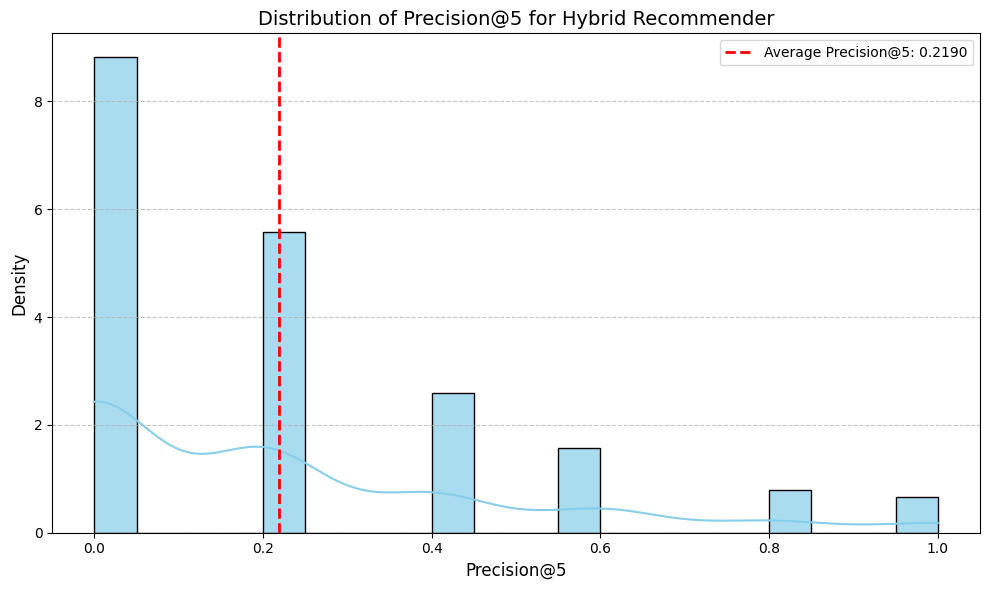

Average Precision@5: 0.2190


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns # Seaborn provides nicer defaults and KDE plots

# Make sure TOP_N is defined somewhere
TOP_N = 5 # Or whatever your actual TOP_N is

# Assume user_precisions list is already populated from your evaluation loop
# average_precision = np.mean(user_precisions)

plt.figure(figsize=(10, 6)) # Make it a bit wider

# Use seaborn's histplot for a combination of histogram and KDE
# histplot arguments:
# data: the data array
# kde: True to draw a kernel density estimate
# bins: number of bins
# stat='density' (or 'probability'): normalizes the bars so they sum to 1
# edgecolor: color of the bar outlines
# color: fill color of the bars
sns.histplot(user_precisions, bins=20, kde=True, stat='density',
             edgecolor='black', color='skyblue', alpha=0.7)

# Add a vertical line for the average precision
plt.axvline(average_precision, color='red', linestyle='dashed', linewidth=2,
            label=f'Average Precision@{TOP_N}: {average_precision:.4f}')

plt.xlabel(f"Precision@{TOP_N}", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title(f"Distribution of Precision@{TOP_N} for Hybrid Recommender", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7) # Grid only on y-axis for cleaner look
plt.legend(fontsize=10) # Display the label for the average line
plt.tight_layout()
plt.show()

print(f"Average Precision@{TOP_N}: {average_precision:.4f}")

In [ ]:
# ------------------ SAVE MODELS ------------------
with open("/Users/sarthakjain/Desktop/Movie recommendation/model /trained_models/trained_tfIDF.joblib", "wb") as f:
    joblib.dump(tfidf, f)

with open("/Users/sarthakjain/Desktop/Movie recommendation/model /trained_models/trained_svd.joblib", "wb") as f:
    joblib.dump(svd, f)

# For Content Similarity Matrix
# Use np.save directly with the file path
np_content_sim_path = "/Users/sarthakjain/Desktop/Movie recommendation/model /trained_models/trained_content_model.npy"
np.save(np_content_sim_path, content_sim)

mapping_data = {
    'Movie_ids': Movie_ids,
    'Movie_id_to_idx': Movie_id_to_idx,
    'ALPHA': ALPHA, # Your best blending weight
    'TOP_N': TOP_N # Your desired number of recommendations
}

joblib.dump(mapping_data, "/Users/sarthakjain/Desktop/Movie recommendation/model /trained_models/recommender_mappings.joblib")


print("Final Hybrid (SVD + Content-Based) Model Saved.")

Final Hybrid (SVD + Content-Based) Model Saved.


In [ ]:
import pandas as pd
#function to return the most popular Movies from each genre as an initial recommendation
ratings_dataframe=pd.read_csv('/Users/sarthakjain/Desktop/Movie recommendation/model /dataset/ratings.csv')
Movies_dataframe=pd.read_csv('/Users/sarthakjain/Desktop/Movie recommendation/model /dataset/Movies.csv')
# Step 3: Merge datasets
data = pd.merge(ratings_dataframe, Movies_dataframe, on='MovieId')

# Step 4: Explode genres (because each Movie can have multiple genres)
data['genres'] = data['genres'].str.split('|')
data_exploded = data.explode('genres')

genre_counts = data_exploded.groupby('genres')['MovieId'].count().sort_values(ascending=False)

# Step 6: Get top 5 genres
top_5_genres = genre_counts.head(5).index.tolist()
top_5_genres

top_Movies = []
for genre in top_5_genres:
    genre_Movies = data_exploded[data_exploded['genres'] == genre]
    most_rated = (
        genre_Movies.groupby(['MovieId', 'title'])
        .size()
        .reset_index(name='num_ratings')
        .sort_values(by='num_ratings', ascending=False)
        .head(20)  # get more than 10 to allow for deduplication
    )
    
    most_rated['genre'] = genre
    top_Movies.append(most_rated)

# Step 8: Combine and remove duplicates based on MovieId
combined = pd.concat(top_Movies, ignore_index=True)
    

# Sort by number of ratings to keep the most popular one if duplicate
combined_unique = combined.sort_values(by='num_ratings', ascending=False).drop_duplicates(subset='MovieId')

# Keep only top 10 from the combined, but keep track of their genre
final_Movies = combined_unique.head(10).reset_index(drop=True)

final_Movies.to_csv('popular_Movies.csv', index=False)

print("Top 10 popular unique Movies from top 5 genres saved successfully!")



In [ ]:
#Creating a combined file for easier and faster use
link_df=pd.read_csv('/Users/sarthakjain/Desktop/Movie recommendation/model /dataset/links.csv', names=['MovieId','imdbId','tmdbId'])

link_df.drop(index=0, inplace=True)
link_df['MovieId'] = pd.to_numeric(link_df['MovieId'], errors='coerce')




Movies_data_for_recs_df = pd.merge(Movies, link_df[['MovieId', 'tmdbId']], on='MovieId', how='left')
Movies_data_for_recs_df.to_csv('combined_data.csv', index=False)
